# MCMC experiment: round 2

Mixture of Gaussians

In [1]:
using Gen
using PyPlot

## Define a model

In [2]:
@gen function gauss_mix(n_clusters::Int64, n_samples::Int64)
    
    cluster_means = [@trace(normal(0.0, 10.0), :means => i) for i=1:n_clusters]
    cluster_spreads = [@trace(gamma(1.0, 1.0), :spreads => i) for i=1:n_clusters]
    cluster_probs = fill(1.0/n_clusters, n_clusters)
    
    z = zeros(n_samples, 1)
    
    for j=1:n_samples
    
        c = @trace(categorical(cluster_probs), :cluster => j)
        z[j] = @trace(normal(cluster_means[c], cluster_spreads[c]), :z => j)
    end
    
    return z

end;

## Sanity check: simulate & visualize

In [3]:
n_samples = 1000
n_clusters = 4
    
tr = simulate(gauss_mix, (n_clusters, n_samples));
zs = [tr[:z => i] for i=1:n_samples];

In [4]:
function plot_choices(zs, means, assignments)
    
    hist_colors = ["gray", "blue", "red", "orange", "yellow"]
    
    z_sets = []
    
    for (i, mean) in enumerate(means)
        plot([mean; mean], [0; n_samples], color="k")
        cluster_z = zs[assignments .== i]
        hist(cluster_z, 20, color=hist_colors[i])
    end
    
end;


function plot_trace(tr)
    
    zs = [tr[:z => j] for j=1:n_samples];
    means = [tr[:means => i] for i=1:n_clusters];
    assignments = [tr[:cluster => j] for j=1:n_samples]
    
    plot_choices(zs, means, assignments)

end;

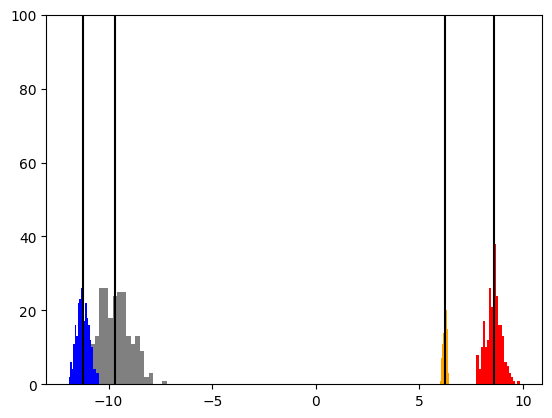

In [5]:
plot_trace(tr)
ylim(0, 100)
show()

## Inference: k-means-initialized MCMC

A straightforward importance sampling approach would have some issues: 
* Sampling (in)efficiency. Sampling the cluster centers from their prior will typically yield very improbable samples.
* (Un)Identifiability. Our model samples the cluster centers iid from a Gaussian. So the next sample will probably put the centers in a very different arrangement!

We can do better than this by:
* Initializing the cluster centers and assignments with a k-means heuristic
* using a custom proposal distribution for updating the cluster centers.
* keeping the cluster centers in sorted order. This eliminates ambiguity when the cluster centers are resampled.

Furthermore, we can improve the sampling speed by performing a customized, inexpensive Gibbs-sampling update for the cluster assignments.

In [7]:
@gen function cluster_mean_proposal(tr, n_clusters)
    for i=1:n_clusters
        @trace(normal(tr[:means => i], 0.25), :means => i)
    end
end

@gen function cluster_spread_proposal(tr, n_clusters)
    for i=1:n_clusters
        @trace(gamma(1.0, 1.0), :spreads => i)
    end
end


function cluster_assignment_gibbs_update(tr, n_clusters, n_data)
    
    # The cluster assignments only ever interact with the 
    # cluster centers in sorted order.
    centers = [tr[:means => i] for i=1:n_clusters]
    srt_inds = sortperm(centers)
    centers = centers[srt_inds]
    spreads = [tr[:spreads => i] for i=1:n_clusters][srt_inds]
    
    new_assignments = Gen.choicemap()
    
    for j=1:n_data
        unnorm_probs = [ exp(-0.5* (tr[:z => j] - centers[i])^2 / (spreads[i]^2)) / spreads[i] for i=1:n_clusters]
        new_assignments[:cluster => j] = categorical(unnorm_probs ./ sum(unnorm_probs))
    end
    
    new_tr, _, _, _ = Gen.update(tr, (n_clusters, n_data), (), new_assignments)
    return new_tr
    
end


cluster_assignment_gibbs_update (generic function with 1 method)

In [8]:
using Statistics

function mean_update(data, cluster_assignments, k)
    return [mean(data[cluster_assignments .== i]) for i=1:k]
end

function cluster_update(data, means)
    
    dists = map(abs, data .- transpose(means))
    min_inds = argmin(dists, dims=2)
    
    return [min_inds[i][2] for i=1:length(min_inds)]
end


function kmeans(data::Array{Float64,1}, k::Int64, max_iter::Int64=1000)
    
    # random initialization
    cluster_assignments = zeros(size(data)[1])
    means = rand(data, k)
    
    i = 1
    while i <= max_iter
        
        cluster_assignments = cluster_update(data, means)
        new_means = mean_update(data, cluster_assignments, k)
        
        if new_means == means
            break
        end
        
        means = new_means
        i += 1
        
    end
    
    # Sort the means in order to ameliorate
    # identifiability issues.
    srt_inds = sortperm(means)
    inv_map = zeros(size(srt_inds))
    for (i, ind) in enumerate(srt_inds)importance sampling
        inv_map[ind] = i
    end
    ca = map(x->inv_map[x], cluster_assignments)
    
    return means[srt_inds], ca
end

kmeans (generic function with 2 methods)

In [9]:
function smarter_mcmc_sample(tr, n_clusters, n_data)
    
    tr, _ = Gen.mh(tr, cluster_mean_proposal, (n_clusters,))
    tr, _ = Gen.mh(tr, cluster_spread_proposal, (n_clusters,))
    tr = cluster_assignment_gibbs_update(tr, n_clusters, n_data)
    
    return tr
end

smarter_mcmc_sample (generic function with 1 method)

In [10]:
function smarter_mcmc_inference(tr, n_samples, n_clusters, n_data, burnin=10, thinning=10)
    
    means = zeros(n_samples, n_clusters)
    spreads = zeros(n_samples, n_clusters)
    assignments = zeros(n_data, n_clusters)
    
    for b=1:burnin
        tr = smarter_mcmc_sample(tr, n_clusters, n_data)
    end
    println("finished burnin; now sampling...")
    for s=1:n_samples
        for t=1:thinning
            tr = smarter_mcmc_sample(tr, n_clusters, n_data)
        end
        
        for i=1:n_clusters
            means[s,i] = tr[:means => i]
            spreads[s,i] = tr[:spreads => i]
        end
        for j=1:n_data
            assignments[j,tr[:cluster => j]] += 1
        end
    end
    
    println("postprocessing...")
    for s=1:n_samples
        srt_inds = sortperm(means[s,:])
        means[s,:] = means[s,srt_inds]
        spreads[s,:] = spreads[s,srt_inds]
    end
        
    return means, spreads, assignments
end

smarter_mcmc_inference (generic function with 3 methods)

In [11]:
function initialize_trace_kmeans(dataset, n_clusters, max_iters=1000)
    
    init_settings = Gen.choicemap()
    means, assignments = kmeans(dataset, n_clusters, max_iters)
    for i=1:n_clusters
        init_settings[:means => i] = means[i]
    end
    for j=1:length(dataset)
        init_settings[:cluster => j] = assignments[j]
        init_settings[:z => j] = dataset[j]
    end
       
    tr, _ = Gen.generate(gauss_mix, (n_clusters, length(dataset)), init_settings)
    
    return tr
end

initialize_trace_kmeans (generic function with 2 methods)

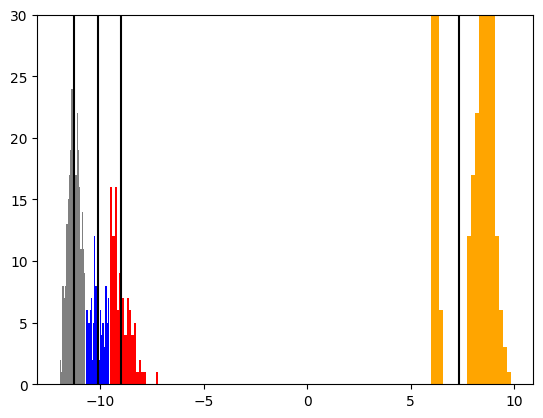

In [35]:
tr = initialize_trace_kmeans(zs, 4)
plot_trace(tr)
ylim(0,30)
show()

In [34]:
means, spreads, assignments = smarter_mcmc_inference(tr, 1000, 4, length(zs), 100, 10)

burning in...
sampling...
postprocessing...


([-10.800932190451645 -10.329384282179516 6.66968981580474 7.976059604294428; -10.800932190451645 -10.329384282179516 6.66968981580474 7.976059604294428; … ; -11.268300060835802 -9.820208508113177 6.22355204436578 8.54431476429221; -11.268300060835802 -9.820208508113177 6.22355204436578 8.54431476429221], [0.8820566073769134 1.7660579321399665 0.9914477809670034 1.5717462640590076; 0.8820566073769134 1.7660579321399665 0.9914477809670034 1.5717462640590076; … ; 0.21987587228368952 0.7106541194704846 0.07910295387826487 0.33732986888342587; 0.21987587228368952 0.7106541194704846 0.07910295387826487 0.33732986888342587], [0.0 0.0 0.0 1000.0; 0.0 0.0 1000.0 0.0; … ; 938.0 62.0 0.0 0.0; 922.0 78.0 0.0 0.0])

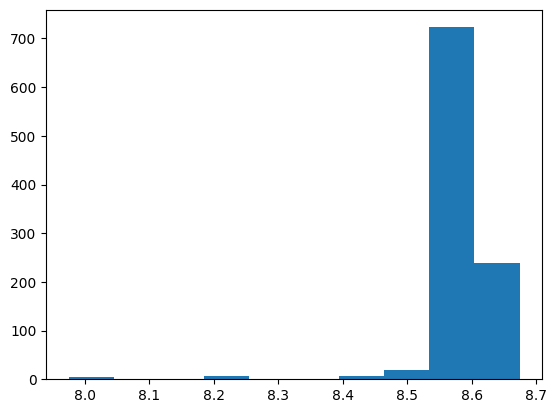

In [39]:
hist(means[:,4])
show()

## Inference: k-means-guided MCMC

